In [2]:
# Synthetic data: 32 animals, 84 binary attributes
np.random.seed(42)
n_animals = 32
n_attrs = 84
props = np.random.binomial(1, 0.3, (n_animals, n_attrs))  # Sparse binary
animal_names = [f'Animal_{i}' for i in range(n_animals)]

def euclidean_dist(a, b):
    return np.sqrt(np.sum((a - b)**2))

def som_1d(props, n_nodes=100, eta=0.2, epochs=20, neigh_start=50):
    w = np.random.uniform(0, 1, (n_nodes, n_attrs))
    for epoch in range(epochs):
        neigh_size = max(1, int(neigh_start * (1 - epoch / epochs)))
        for i in range(n_animals):
            p = props[i]
            dists = np.array([euclidean_dist(p, w[j]) for j in range(n_nodes)])
            winner = np.argmin(dists)
            for j in range(n_nodes):
                if abs(j - winner) <= neigh_size:
                    w[j] += eta * (p - w[j])
    # Map animals to winners
    pos = np.zeros(n_animals, dtype=int)
    for i in range(n_animals):
        p = props[i]
        dists = np.array([euclidean_dist(p, w[j]) for j in range(n_nodes)])
        pos[i] = np.argmin(dists)
    # Sort by pos
    sorted_idx = np.argsort(pos)
    ordered_animals = [animal_names[i] for i in sorted_idx]
    print("Ordered Animals:", ordered_animals)
    return ordered_animals, w

ordered, w_final = som_1d(props)
# Interpretation: Similar animals (high attr overlap) should cluster.

Ordered Animals: ['Animal_1', 'Animal_28', 'Animal_6', 'Animal_26', 'Animal_25', 'Animal_19', 'Animal_31', 'Animal_21', 'Animal_0', 'Animal_15', 'Animal_29', 'Animal_27', 'Animal_8', 'Animal_20', 'Animal_18', 'Animal_17', 'Animal_3', 'Animal_30', 'Animal_12', 'Animal_5', 'Animal_22', 'Animal_23', 'Animal_9', 'Animal_10', 'Animal_14', 'Animal_11', 'Animal_7', 'Animal_2', 'Animal_4', 'Animal_16', 'Animal_24', 'Animal_13']


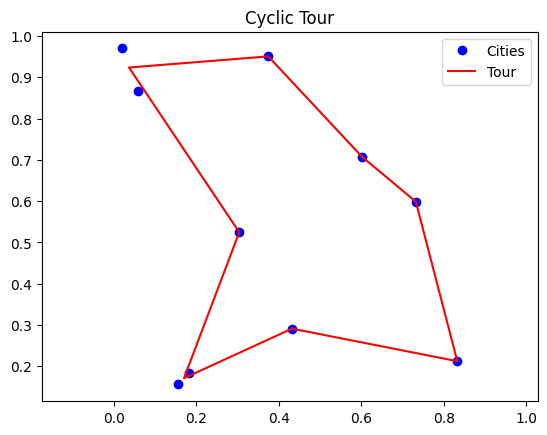

In [3]:
# Synthetic cities: 10 points in [0,1]^2
np.random.seed(42)
n_cities = 10
city = np.random.uniform(0, 1, (n_cities, 2))

def som_cyclic(city, n_nodes=10, eta=0.2, epochs=100, neigh_start=2):
    w = np.random.uniform(0, 1, (n_nodes, 2))
    for epoch in range(epochs):
        neigh_size = max(0, int(neigh_start * (1 - epoch / epochs)))
        for i in range(n_cities):
            p = city[i]
            dists = np.linalg.norm(w - p, axis=1)
            winner = np.argmin(dists)
            for j in range(n_nodes):
                # Circular distance
                dist_circ = min(abs(j - winner), n_nodes - abs(j - winner))
                if dist_circ <= neigh_size:
                    w[j] += eta * (p - w[j])
    return w

w_tour = som_cyclic(city)

# Plot
plt.figure()
plt.plot(city[:, 0], city[:, 1], 'bo', label='Cities')
# Close the tour
tour_x = np.append(w_tour[:, 0], w_tour[0, 0])
tour_y = np.append(w_tour[:, 1], w_tour[0, 1])
plt.plot(tour_x, tour_y, 'r-', label='Tour')
plt.legend()
plt.title('Cyclic Tour')
plt.axis('equal')
plt.show()

# Interpretation: The tour connects centers near cities in a loop, approximating TSP.

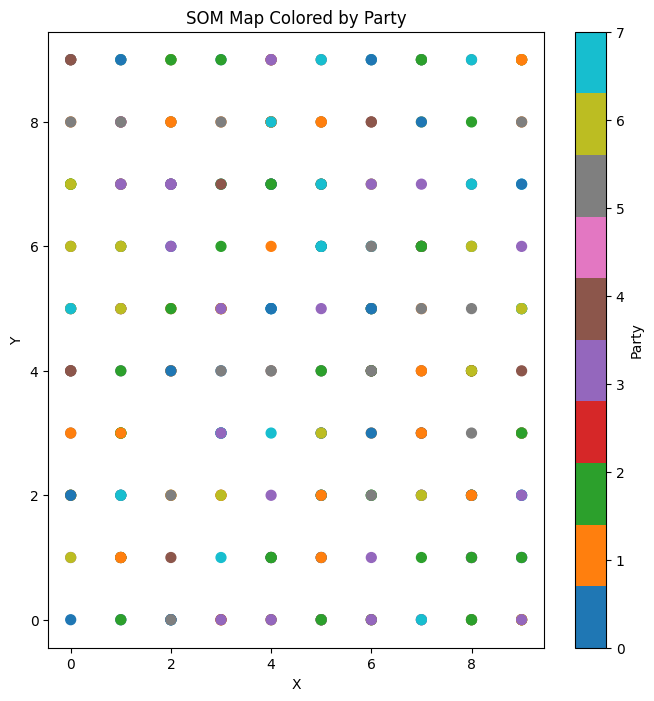

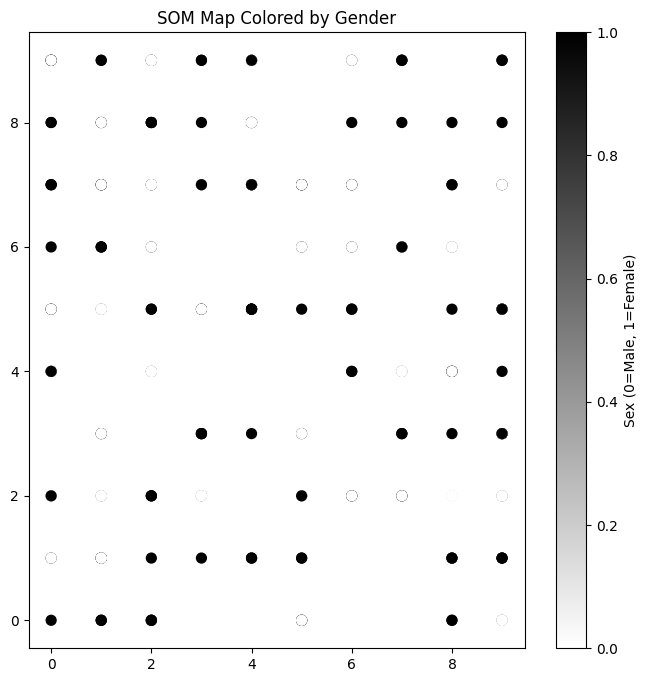

In [4]:
# Synthetic votes: 349 MPs, 31 votes, 0/0.5/1
np.random.seed(42)
n_mps = 349
n_votes = 31
votes = np.random.choice([0, 0.5, 1], (n_mps, n_votes), p=[0.4, 0.1, 0.5])

# Synthetic attributes
n_parties = 8  # e.g., Swedish parties
mpparty = np.random.choice(n_parties, n_mps)
mpsex = np.random.choice([0, 1], n_mps)  # 0 male, 1 female
mpdistrict = np.random.choice(29, n_mps)  # 29 districts

def som_2d(votes, grid_size=10, eta=0.2, epochs=100, neigh_start=5):
    n_nodes = grid_size ** 2
    w = np.random.uniform(0, 1, (n_nodes, n_votes))
    for epoch in range(epochs):
        neigh_size = max(1, int(neigh_start * (1 - epoch / epochs)))
        for i in range(n_mps):
            p = votes[i]
            dists = np.linalg.norm(w - p, axis=1)
            winner = np.argmin(dists)
            for j in range(n_nodes):
                # Manhattan in grid
                row_w, col_w = divmod(winner, grid_size)
                row_j, col_j = divmod(j, grid_size)
                manh = abs(row_j - row_w) + abs(col_j - col_w)
                if manh <= neigh_size:
                    w[j] += eta * (p - w[j])
    return w.reshape(grid_size, grid_size, n_votes)

w_map = som_2d(votes)

# Map MPs to grid
winners = np.zeros(n_mps, dtype=int)
for i in range(n_mps):
    p = votes[i]
    dists = np.linalg.norm(w_map.reshape(-1, n_votes) - p, axis=1)
    winners[i] = np.argmin(dists)
grid_pos = np.unravel_index(winners, (10, 10))

# Visualize party (color by party)
plt.figure(figsize=(8, 8))
scatter = plt.scatter(grid_pos[1], grid_pos[0], c=mpparty, cmap='tab10', s=50)
plt.colorbar(scatter, ticks=range(n_parties), label='Party')
plt.title('SOM Map Colored by Party')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Similar for sex, district
plt.figure(figsize=(8, 8))
scatter_sex = plt.scatter(grid_pos[1], grid_pos[0], c=mpsex, cmap='binary', s=50)
plt.colorbar(scatter_sex, label='Sex (0=Male, 1=Female)')
plt.title('SOM Map Colored by Gender')
plt.show()

# Interpretation: Parties cluster along one axis (left-right), gender/district show if biases exist (synthetic: random, no strong patterns).